In [1]:
import cv2
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.func import (get_pictures, apply_hough_transformation, group_lines, fill_edges_image, get_closest_line, traverse_line, transform_line)
from utils.lines import Line, Point
from utils.corners import CourtFinder

mpl.rcParams['image.cmap'] = 'gray'

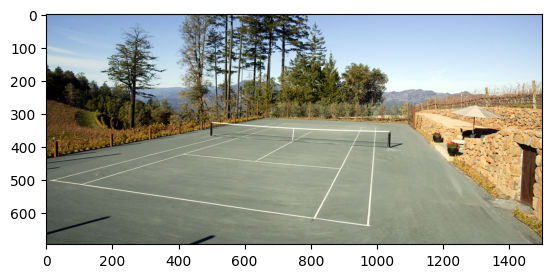

In [2]:
pic_index = 7
train_pic = get_pictures('pics/compliant')['rgb'][pic_index] 
plt.imshow(train_pic)
plt.show()

with open('test.config.json') as file:
    config = json.load(file)

conf = config['data'][pic_index]

y = -0.5269709543568465 * x + 775.6597510373444


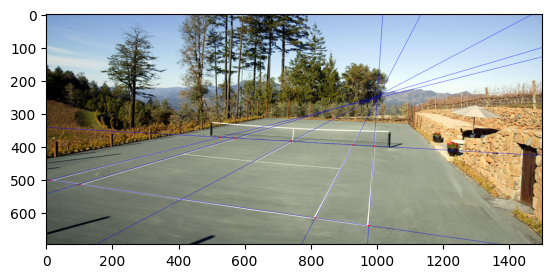

In [ ]:
train_pic_hough_lines, line_endpoints = apply_hough_transformation(train_pic)
line_objs = [Line.from_hough_line(line[0]) for line in line_endpoints]
line_objs = [line for line in line_objs if line.xv is None]

grouped_lines = group_lines(line_objs)


train_pic_line_intersections = train_pic.copy()
intersections = []
for group1 in grouped_lines:
    for group2 in grouped_lines:
        intersection = group1.intersection(group2, train_pic_line_intersections)
        if intersection is not None:
            intersections.append(intersection)


candidates = CourtFinder(intersections, train_pic)


# closer_outer_baseline_point, closer_outer_netpoint, closer_doubles_sideline -------
closer_outer_baseline_intersecetion, closer_outer_netintersection, used_line = candidates.find_closer_outer_baseline_point()
closer_outer_baseline_point = closer_outer_baseline_intersecetion.point
closer_outer_netline_point = closer_outer_netintersection.point
closer_doubles_sideline = Line.from_points(closer_outer_baseline_point, closer_outer_netline_point)

# further_outer_baseline_point, baseline  -------
further_outer_baseline_intersection, last_local_line = candidates.find_further_outer_baseline_intersection(closer_outer_baseline_intersecetion, used_line, conf['canny_thresh']['lower'] , conf['canny_thresh']['upper'], offset=conf['offset'])
further_outer_baseline_point = further_outer_baseline_intersection.point
baseline = Line.from_points(closer_outer_baseline_point, further_outer_baseline_point)

# netline -----
netline = candidates.find_netline(closer_outer_netline_point, baseline, conf['max_line_gap'])

# further_doubles_sideline, further_outer_netpoint ---
further_doubles_sideline = candidates.find_further_doubles_sideline(further_outer_baseline_point, last_local_line, conf['offset'], conf['extra_offset'], conf['bin_thresh'], conf['surface_type'])
further_outer_netline_point = further_doubles_sideline.intersection(netline, train_pic).point

# inner points

# closer_inner_baseline_point, further_inner_baseline_point, closer_inner_netpoint, further_inner_netpoint = candidates.scan_baseline(baseline, 
#                                                                                                                                     netline, 
#                                                                                                                                     closer_outer_baseline_point, 
#                                                                                                                                     further_outer_netpoint, 
#                                                                                                                                     closer_outer_netpoint, 
#                                                                                                                                     further_outer_baseline_intersection_point, 
#                                                                                                                                     conf['bin_thresh_baseline_scan'],
#                                                                                                                                     conf['canny_thresh']['lower'],
#                                                                                                                                     conf['canny_thresh']['upper'],
#                                                                                                                                     conf['max_line_gap'],
#                                                                                                                                     )


closer_inner_baseline_point, further_inner_baseline_point = candidates.scan_endline(baseline,
                                                                                    netline, 
                                                                                    closer_outer_baseline_point, 
                                                                                    further_outer_netline_point, 
                                                                                    closer_outer_netline_point, 
                                                                                    further_outer_baseline_point, 
                                                                                    conf['bin_thresh_endline_scan']['baseline'],
                                                                                    conf['canny_thresh']['lower'],
                                                                                    conf['canny_thresh']['upper'],
                                                                                    conf['max_line_gap'],
                                                                                    searching_line = 'base',
                                                                                    )


closer_inner_netline_point, further_inner_netline_point = candidates.scan_endline(baseline,
                                                                                    netline, 
                                                                                    closer_outer_baseline_point, 
                                                                                    further_outer_netline_point, 
                                                                                    closer_outer_netline_point, 
                                                                                    further_outer_baseline_point, 
                                                                                    conf['bin_thresh_endline_scan']['netline'],
                                                                                    conf['canny_thresh']['lower'],
                                                                                    conf['canny_thresh']['upper'],
                                                                                    conf['max_line_gap'],
                                                                                    searching_line = 'net',
                                                                                    )


closer_singles_sideline = Line.from_points(closer_inner_baseline_point, closer_inner_netline_point)
further_singles_sideline = Line.from_points(further_inner_baseline_point, further_inner_netline_point)


# service points
net_service_point, centre_service_line = candidates.find_net_service_point_centre_service_line(closer_outer_baseline_point, 
                                                                        closer_outer_netline_point, 
                                                                        further_outer_baseline_point,
                                                                        further_outer_netline_point, 
                                                                        closer_inner_baseline_point,
                                                                        further_inner_baseline_point,
                                                                        closer_inner_netline_point,
                                                                        further_inner_netline_point,
                                                                        baseline, 
                                                                        netline,
                                                                        conf['bin_thresh_centre_service_line'],
                                                                        conf['canny_thresh']['lower'],
                                                                        conf['canny_thresh']['upper'],
                                                                        conf['max_line_gap_centre_service_line'],
                                                                        conf['min_line_len_ratio'],
                                                                        conf['hough_thresh'],
                                                                        )


pic = train_pic.copy()
pts1 = closer_doubles_sideline.limit_to_img(pic)
pts2 = baseline.limit_to_img(pic)
pts3 = netline.limit_to_img(pic)
pts4 = further_doubles_sideline.limit_to_img(pic)
pts5 = closer_singles_sideline.limit_to_img(pic)
pts6 = further_singles_sideline.limit_to_img(pic)
pts7 = centre_service_line.limit_to_img(pic)

cv2.line(pic, *pts1, (0, 0, 255))
cv2.line(pic, *pts2, (0, 0, 255))
cv2.line(pic, *pts3, (0, 0, 255))
cv2.line(pic, *pts4, (0, 0, 255))
cv2.line(pic, *pts5, (0, 0, 255))
cv2.line(pic, *pts6, (0, 0, 255))
cv2.line(pic, *pts7, (0, 0, 255))

cv2.circle(pic, closer_outer_netline_point, 1, (255, 0,0), 3, -1)
cv2.circle(pic, closer_outer_baseline_point, 1, (255,0,0), 3, -1)
cv2.circle(pic, further_outer_baseline_point, 1, (255,0,0), 3, -1)
cv2.circle(pic, further_outer_netline_point, 1, (255,0,0), 3, -1)

cv2.circle(pic, closer_inner_baseline_point, 1, (255,0,0), 3, -1)
cv2.circle(pic, closer_inner_netline_point, 1, (255,0,0), 3, -1)
cv2.circle(pic, further_inner_baseline_point, 1, (255,0,0), 3, -1)
cv2.circle(pic, further_inner_netline_point, 1, (255,0,0), 3, -1)

cv2.circle(pic, net_service_point, 1, (255,0,0), 3, -1)

plt.imshow(pic)
plt.show()



In [ ]:
# pic = train_pic.copy()
# bin_thresh = 0.75 #0.6
# offset = 25
# new_point = closer_outer_baseline_point
# further_outer_netpoint
# closer_outer_netpoint
# further_outer_baseline_intersection_point
# netline
# warmup = 2
# further_outer_baseline_point_tolerance = 3
# baseline_points_max = []
# baseline_points_min = []
# i = 0
# while True:

#     i += 1

#     new_point, img_piece, (origin_x, origin_y) = traverse_line(new_point, offset, pic, baseline, neighbourhood_type='simple')
#     pt_end = Point(origin_x + img_piece.shape[1], origin_y + img_piece.shape[0])
#     img_gray = cv2.cvtColor(img_piece, cv2.COLOR_RGB2GRAY)

#     if i <= warmup:
#         continue

#     bin_img = (img_gray > img_gray.max() * bin_thresh).astype(np.uint8) * 255

#     print(bin_img.max(), bin_img.min())

#     edges = cv2.Canny(bin_img, 20, 80)

#     lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=20, minLineLength=offset*0.5, maxLineGap=10)
#     lines = [] if lines is None else lines

#     line_obj = [Line.from_hough_line(line[0]) for line in lines]
#     line_obj = [line for line in line_obj if line.slope is not None and np.sign(line.slope) != np.sign(baseline.slope)]

#     grouped_lines = group_lines(line_obj)
#     print(f"groups len:   {len(grouped_lines)}")

#     plt.imshow(edges)
#     plt.show()

#     local_baseline = transform_line(baseline, train_pic, origin_x, origin_y, False)

#     for line in grouped_lines:

#         for line_type in ('min', 'max'):
#             local_line = line.get_line(line_type)
#             global_line = transform_line(local_line, train_pic, origin_x, origin_y)
#             test_intersection_point = global_line.intersection(netline, train_pic).point


#             if closer_outer_netpoint.x < test_intersection_point.x < further_outer_netpoint.x or closer_outer_netpoint.x > test_intersection_point.x > further_outer_netpoint.x:
#                 baseline_intersection_point = global_line.intersection(baseline, train_pic).point

#                 local_intersection = local_line.intersection(local_baseline, img_piece)


#                 if (local_intersection is not None) and not (baseline_intersection_point.x - further_outer_baseline_point_tolerance < further_outer_baseline_intersection_point.x < baseline_intersection_point.x + further_outer_baseline_point_tolerance and further_outer_baseline_intersection_point.y - further_outer_baseline_point_tolerance < baseline_intersection_point.y < further_outer_baseline_intersection_point.y + further_outer_baseline_point_tolerance):

#                     if line_type == 'min':
#                         print('min linetype')
#                         baseline_points_min.append((baseline_intersection_point, test_intersection_point))
#                     else:
#                         print('max linetype')
#                         baseline_points_max.append((baseline_intersection_point, test_intersection_point))


#     img_copy = img_piece.copy()
#     for line in grouped_lines:
#         # x1, y1, x2, y2 = line[0]
#         # cv2.line(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
#         pts = line.limit_to_img(img_copy)
#         pts_base = local_baseline.limit_to_img(img_copy)
#         cv2.line(img_copy, *pts, (255, 0,0), 1)
#         cv2.line(img_copy, *pts_base, (0, 255, 0), 1)

#     plt.imshow(img_copy)
#     plt.show()


#     if further_outer_baseline_intersection_point.is_in_area(Point(origin_x, origin_y), pt_end):
#         break

# # print(baseline_points)

NameError: name 'further_outer_baseline_intersection_point' is not defined

In [ ]:
# filtered_baseline_points = 
# print(baseline_points_min)
# print(baseline_points_max)


# baseline_points_max

[(Point(714, 999), Point(1098, 591)), (Point(157, 739), Point(684, 511))]
[(Point(708, 996), Point(1111, 593)), (Point(153, 737), Point(699, 514))]


In [ ]:
baseline_points_min[0]

(Point(715, 999), Point(1073, 586))

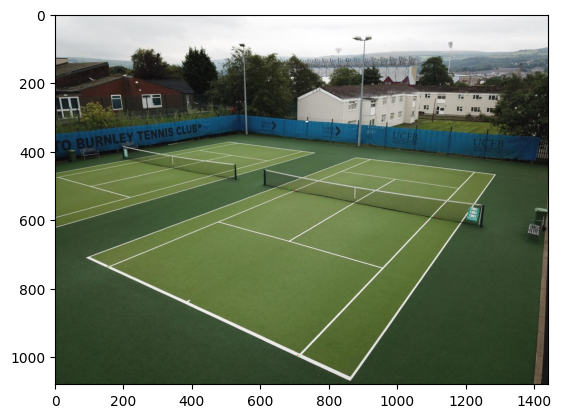

In [ ]:
# pic = train_pic.copy()

# for point_min, point_max in zip(baseline_points_min, baseline_points_max):
#     base_min, net_min = point_min
#     base_max, net_max = point_max
#     cv2.circle(pic, base_min, 2, (0, 255,0), 1, -1)
#     cv2.circle(pic, net_min, 2, (0, 255,0), 1, -1)
#     cv2.circle(pic, base_max, 2, (255, 0,0), 1, -1)
#     cv2.circle(pic, net_max, 2, (255, 0,0), 1, -1)

# plt.imshow(pic)
# plt.show()

In [ ]:
# closer_inner_baseline_point = baseline_points_min[0][0]
# closer_inner_netpoint = baseline_points_min[0][1]

# further_inner_baseline_point = baseline_points_max[-1][0]
# further_inner_netpoint = baseline_points_max[-1][1]

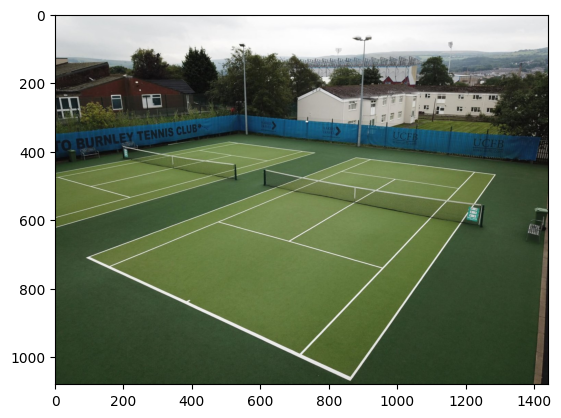

In [ ]:
plt.imshow(train_pic)

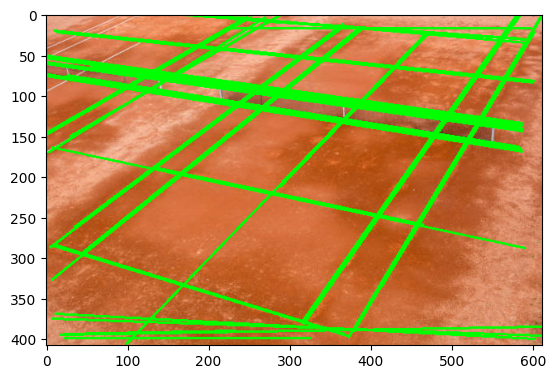

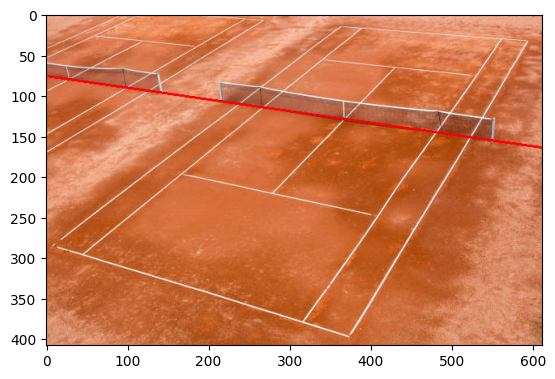

In [ ]:
pic_copy = train_pic.copy()

netline_focused = pic_copy.copy()

img_gray = cv2.cvtColor(netline_focused, cv2.COLOR_RGB2GRAY)
inv_img_gray = 255 - img_gray


# plt.imshow(img_gray)
# plt.show()

# plt.imshow(inv_img_gray)
# plt.show()

edges = cv2.Canny(inv_img_gray, 50, 150)

lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=100)
if lines is None:
    lines = []

img_copy = netline_focused.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
plt.imshow(img_copy)
plt.show()

line_obj = [Line.from_hough_line(line[0]) for line in lines]
line_obj = [line for line in line_obj if line.slope is not None and np.sign(line.slope) == np.sign(baseline.slope)]

closest_line = get_closest_line(line_obj, closer_outer_netpoint)

pts = closest_line.limit_to_img(netline_focused)
cv2.line(pic_copy, *pts3, (255, 0, 0), 2)

plt.imshow(pic_copy)

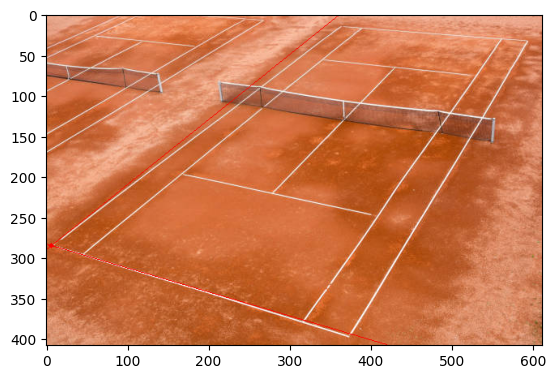

In [ ]:
pic_copy = train_pic.copy()
further_outer_baseline_intersection_point = further_outer_baseline_intersection.point
pts1 = further_outer_baseline_intersection.line1.limit_to_img(pic_copy)
pts2 = further_outer_baseline_intersection.line2.limit_to_img(pic_copy)

cv2.line(pic_copy, *pts1, (255, 0, 0))
cv2.line(pic_copy, *pts2, (255, 0, 0))
cv2.circle(pic_copy, further_outer_baseline_intersection_point, 1, (255, 0,0), 3, -1)

plt.imshow(pic_copy)
plt.show()


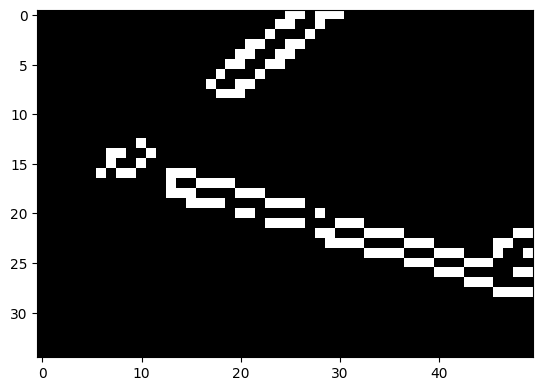

In [ ]:
pic = train_pic[270:305, 0:50]
pic_gray = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(pic_gray, 150, 200)
filled = fill_edges_image(edges)

plt.imshow(edges)

In [ ]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=10, minLineLength=10, maxLineGap=10)
if lines is None:
    lines = []

line_obj = [Line.from_hough_line(line[0]) for line in lines]
line_obj = [line for line in line_obj if line.slope is not None] 
grouped_lines = group_lines(line_obj)

img_copy = pic.copy()
for line in grouped_lines:
    pts = line.limit_to_img(img_copy)
    cv2.line(img_copy, *pts, (0, 255, 0), 1)

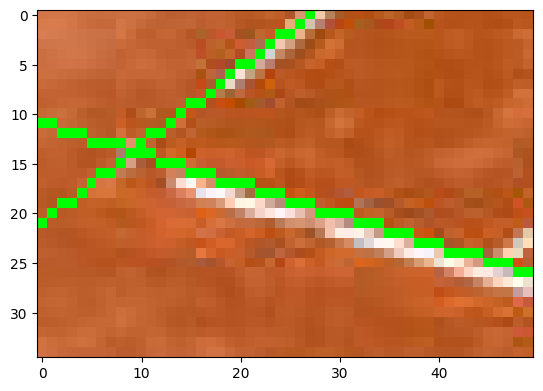

In [ ]:
plt.imshow(img_copy)

TypeError: Image data of dtype object cannot be converted to float

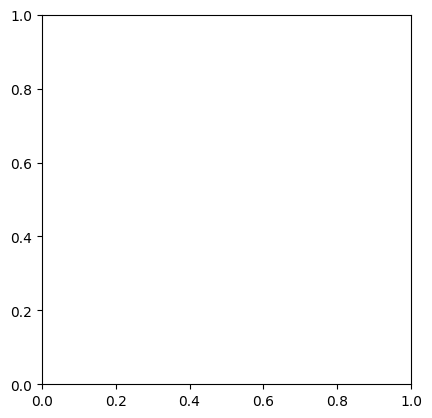

In [ ]:
piece = pic[490:510, 0:50].copy()
edge = cv2.Canny(piece, 50, 150)
plt.imshow(edge)
plt.show()

In [ ]:
seq = {0, 1}

y = -1.0 * x + 5.0


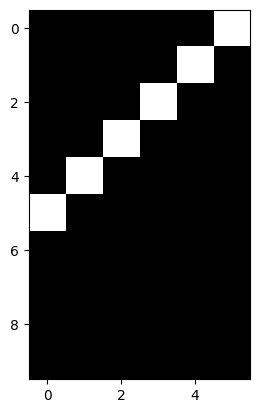

In [ ]:
img = np.eye(10, 6)

img = np.array([
    [0,0,0,0,0,1],
    [0,0,0,0,1,0],
    [0,0,0,1,0,0],
    [0,0,1,0,0,0],
    [0,1,0,0,0,0],
    [1,0,0,0,0,0],
    [0,0,0,0,0,0],
    [0,0,0,0,0,0],
    [0,0,0,0,0,0],
    [0,0,0,0,0,0],
])


line = Line.from_points((0,5), (5,0))
print(line)
plt.imshow(img)
plt.show()

In [ ]:
for col_idx in range(img.shape[1]):

    row_idx = line.y_for_x(col_idx)

    print(img[row_idx, col_idx])
    

1
1
1
1
1
1
